In [34]:
import pandas as pd
from pycaret.classification import *
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# 오버 샘플링을 위한 라이브러리
from imblearn.over_sampling import SMOTENC

In [35]:
df = pd.read_csv('./features.csv', sep='\t', encoding='utf-8')

df = df.dropna().drop(columns=['Unnamed: 0', 'datetime']).reset_index(drop=True)
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [36]:
# 각 ID별로 SMOTE-NC를 적용
def smote_nc_per_id(data, id_column, target_column, categorical_features):
    resampled_data = pd.DataFrame()
    ids = data[id_column].unique()
    
    for _id in ids:
        subset = data[data[id_column] == _id]
        X = subset.drop(columns=[target_column])
        y = subset[target_column]
        
        smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
        X_resampled, y_resampled = smote_nc.fit_resample(X, y)
        
        resampled_subset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=[target_column])], axis=1)
        resampled_data = pd.concat([resampled_data, resampled_subset], axis=0)
        
    resampled_data.reset_index(drop=True, inplace=True)
    return resampled_data

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

label
PersNorm    71.114291
PersHigh    15.206683
PersLow     13.679025
Name: proportion, dtype: float64


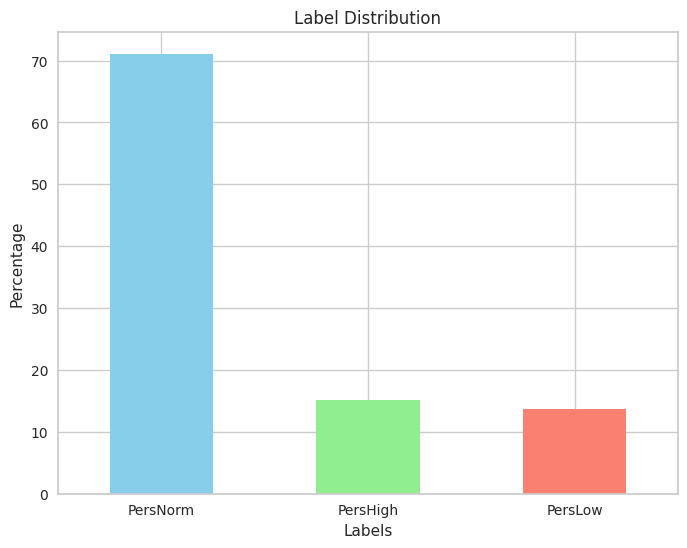

In [37]:
label_distribution = df['label'].value_counts(normalize=True) * 100
print(label_distribution)

plt.figure(figsize=(8, 6))
label_distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [38]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh': 2})

X = df.drop(columns=['label', 'glucose'])
y = df['label']
# SMOTE-NC 적용
categorical_features = ['Biological Sex', 'ID']
categorical_features_indices = [df.columns.get_loc(col) for col in categorical_features]
resampled_df = smote_nc_per_id(df, 'ID', 'label', categorical_features)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

label
1    33.333333
0    33.333333
2    33.333333
Name: proportion, dtype: float64


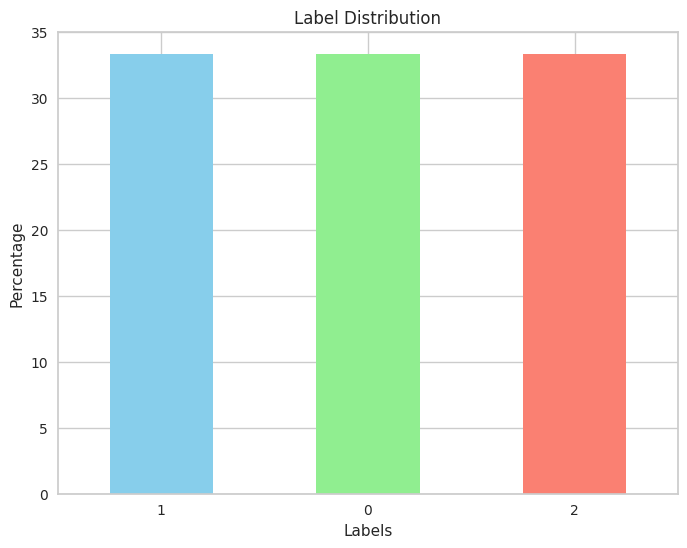

In [39]:
label_distribution = resampled_df['label'].value_counts(normalize=True) * 100
print(label_distribution)

plt.figure(figsize=(8, 6))
label_distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

In [40]:
print(f"Data length (Before Resampling): {len(df)}")
print(f"Data_resampled length (After Resampling): {len(resampled_df)}")

print()
class_counts = df['label'].map({0:'PersLow',1:'PersNorm',2:'PersHigh'}).value_counts()
print('############# Before Resampling ############')
print(class_counts)

class_counts = resampled_df['label'].map({0:'PersLow',1:'PersNorm',2:'PersHigh'}).value_counts()
print('############# After Resampling ############')
print(class_counts)

Data length (Before Resampling): 30046
Data_resampled length (After Resampling): 64101

############# Before Resampling ############
label
PersNorm    21367
PersHigh     4569
PersLow      4110
Name: count, dtype: int64
############# After Resampling ############
label
PersNorm    21367
PersLow     21367
PersHigh    21367
Name: count, dtype: int64


In [41]:
exp = setup(data=resampled_df,
            target='label',
            fold=10,        # 10-fold
            train_size=0.7, # training size 0.7:0.3
            fold_strategy='stratifiedkfold',
            fold_shuffle=True,
            feature_selection=True,
            feature_selection_estimator='rf',
            feature_selection_method='classic',
            n_features_to_select=15,
            session_id=123,
            use_gpu=False,
            verbose=True,
            n_jobs=4
            )

best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(64101, 77)"
4,Transformed data shape,"(64101, 16)"
5,Transformed train set shape,"(44870, 16)"
6,Transformed test set shape,"(19231, 16)"
7,Numeric features,76
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9837,0.9994,0.9837,0.9838,0.9837,0.9756,0.9756,8.1590
et,Extra Trees Classifier,0.9794,0.9992,0.9794,0.9795,0.9793,0.9691,0.9693,7.8570
lightgbm,Light Gradient Boosting Machine,0.9783,0.9986,0.9783,0.9784,0.9783,0.9675,0.9676,7.9220
dt,Decision Tree Classifier,0.9710,0.9783,0.9710,0.9710,0.9710,0.9565,0.9566,7.2330
knn,K Neighbors Classifier,0.9280,0.9841,0.9280,0.9282,0.9272,0.8920,0.8928,7.3770
gbc,Gradient Boosting Classifier,0.9149,0.0000,0.9149,0.9148,0.9141,0.8724,0.8730,15.6200
lr,Logistic Regression,0.7948,0.0000,0.7948,0.7950,0.7947,0.6922,0.6925,9.2540
qda,Quadratic Discriminant Analysis,0.7813,0.0000,0.7813,0.7857,0.7825,0.6720,0.6728,7.6020
lda,Linear Discriminant Analysis,0.7813,0.0000,0.7813,0.7891,0.7831,0.6720,0.6735,7.2900
ridge,Ridge Classifier,0.7408,0.0000,0.7408,0.7392,0.7245,0.6112,0.6242,7.2620
